In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
import pickle
import os
from datasets import load_dataset


d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectorize_layer = None
models = {}
histories = {}
vocab_size = 10000
sequence_length = 100
embedding_dim = 128
results={}

In [3]:
#Load dataset
dataset = load_dataset("indonlp/NusaX-senti", "ind")

# Extract texts and labels from the dataset
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Convert to lists
train_texts = train_data['text']
train_labels = train_data['label']
val_texts = val_data['text']
val_labels = val_data['label']
test_texts = test_data['text']
test_labels = test_data['label']

print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

unique_labels, counts = np.unique(train_labels, return_counts=True)
print(f"Label distribution in training set:")
for label, count in zip(unique_labels, counts):
    print(f"  Label {label}: {count} samples")



Train size: 500
Validation size: 100
Test size: 400
Label distribution in training set:
  Label 0: 192 samples
  Label 1: 119 samples
  Label 2: 189 samples


In [4]:
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
    output_mode='int'
)

# Adapt to training data
vectorize_layer.adapt(train_texts)

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
train_ds = train_ds.map(lambda x, y: (vectorize_layer(x), y))
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_texts, val_labels))
val_ds = val_ds.map(lambda x, y: (vectorize_layer(x), y))
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))
test_ds = test_ds.map(lambda x, y: (vectorize_layer(x), y))
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
def create_model(num_lstm_layers=1, lstm_units=64, bidirectional=False):

    model = keras.Sequential()

    # Embedding layer
    model.add(layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length
    ))

    # LSTM layers
    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)  # Only last layer returns single output

        if bidirectional:
            model.add(layers.Bidirectional(
                layers.LSTM(lstm_units, return_sequences=return_sequences, dropout=0.2)
            ))
        else:
            model.add(layers.LSTM(lstm_units, return_sequences=return_sequences, dropout=0.2))

    # Dropout layer
    model.add(layers.Dropout(0.5))

    # Determine number of classes dynamically
    num_classes = len(set(train_labels))
    print(f"Number of classes detected: {num_classes}")

    # Dense layer for classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [6]:
def variations_train(layer_configs, unit_configs, direction_configs):
    #variasi konfigurasi model
    epochs = 10

    for num_layers in layer_configs:
        model_name = f"layers_{num_layers}"
        print(f"Training model with {num_layers} LSTM layer(s)")

        model = create_model(
            num_lstm_layers=num_layers,
            lstm_units=64,
            bidirectional=False
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1
        )

        models[model_name] = model
        histories[model_name] = history
        predictions = model.predict(test_ds)
        predicted_labels = np.argmax(predictions, axis=1)

        # Calculate macro F1 score
        f1_macro = f1_score(test_labels, predicted_labels, average='macro')

        results[model_name] = {
            'f1_macro': f1_macro,
            'predictions': predicted_labels
        }

    for units in unit_configs:
        model_name = f"units_{units}"
        print(f"Training model with {units} LSTM units")

        model = create_model(
            num_lstm_layers=1,
            lstm_units=units,
            bidirectional=False
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1
        )

        models[model_name] = model
        histories[model_name] = history
        predictions = model.predict(test_ds)
        predicted_labels = np.argmax(predictions, axis=1)

        # Calculate macro F1 score
        f1_macro = f1_score(test_labels, predicted_labels, average='macro')

        results[model_name] = {
            'f1_macro': f1_macro,
            'predictions': predicted_labels
        }

    for is_bidirectional in direction_configs:
        direction_name = "bidirectional" if is_bidirectional else "unidirectional"
        model_name = f"direction_{direction_name}"
        print(f"Training {direction_name} model")

        model = create_model(
            num_lstm_layers=1,
            lstm_units=64,
            bidirectional=is_bidirectional
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1
        )

        models[model_name] = model
        histories[model_name] = history
        predictions = model.predict(test_ds)
        predicted_labels = np.argmax(predictions, axis=1)

        # Calculate macro F1 score
        f1_macro = f1_score(test_labels, predicted_labels, average='macro')

        results[model_name] = {
            'f1_macro': f1_macro,
            'predictions': predicted_labels
        }
    return models

In [7]:
def plot_training_curves():
    #plot loss
    plt.figure(figsize=(15, 12))

    # Group models by variation type
    layer_models = [name for name in models.keys() if name.startswith('layers_')]
    unit_models = [name for name in models.keys() if name.startswith('units_')]
    direction_models = [name for name in models.keys() if name.startswith('direction_')]

    # Plot layer variation
    plt.subplot(2, 3, 1)
    for model_name in layer_models:
        history = histories[model_name]
        plt.plot(history.history['loss'], label=f'{model_name} train')
    plt.title('Training Loss - Layer Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    for model_name in layer_models:
        history = histories[model_name]
        plt.plot(history.history['val_loss'], label=f'{model_name} val')
    plt.title('Validation Loss - Layer Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot unit variation
    plt.subplot(2, 3, 3)
    for model_name in unit_models:
        history = histories[model_name]
        plt.plot(history.history['loss'], label=f'{model_name} train')
    plt.title('Training Loss - Unit Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 4)
    for model_name in unit_models:
        history = histories[model_name]
        plt.plot(history.history['val_loss'], label=f'{model_name} val')
    plt.title('Validation Loss - Unit Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot direction variation
    plt.subplot(2, 3, 5)
    for model_name in direction_models:
        history = histories[model_name]
        plt.plot(history.history['loss'], label=f'{model_name} train')
    plt.title('Training Loss - Direction Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 6)
    for model_name in direction_models:
        history = histories[model_name]
        plt.plot(history.history['val_loss'], label=f'{model_name} val')
    plt.title('Validation Loss - Direction Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [8]:
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def save_models(models):
    """Save trained models and weights"""
    print("\nSaving models...")

    if not os.path.exists('lstm_models'):
        os.makedirs('lstm_models')

    for model_name, model in models.items():
        model.save(f'lstm_models/{model_name}.keras')
        print(f"Saved {model_name}.keras")

In [10]:
layer_configs = [1, 2, 3]
unit_configs = [32, 64, 128]
direction_configs = [False, True]
models = variations_train(layer_configs, unit_configs, direction_configs)

Training model with 1 LSTM layer(s)
Number of classes detected: 3
Epoch 1/10


d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.3372 - loss: 1.1029 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3780 - loss: 1.0783 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3991 - loss: 1.0809 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3613 - loss: 1.0882 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3818 - loss: 1.0845 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3824 - loss: 1.0836 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3014 - loss: 1.0925 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3537 - loss: 1.0860 - val_accuracy: 0.3800 - val_loss: 1.

d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.3744 - loss: 1.0910 - val_accuracy: 0.3800 - val_loss: 1.0833
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.3560 - loss: 1.0938 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4146 - loss: 1.0758 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3729 - loss: 1.0863 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3323 - loss: 1.0926 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.3563 - loss: 1.0802 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.3854 - loss: 1.0766 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.3221 - loss: 1.0899 - val_accuracy: 0.3800 - val_loss: 

d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.3695 - loss: 1.0920 - val_accuracy: 0.3800 - val_loss: 1.0818
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.3653 - loss: 1.0912 - val_accuracy: 0.3800 - val_loss: 1.0806
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4015 - loss: 1.0813 - val_accuracy: 0.3800 - val_loss: 1.0806
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3238 - loss: 1.0890 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.3418 - loss: 1.0802 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.3358 - loss: 1.0837 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3786 - loss: 1.0856 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3552 - loss: 1.0836 - val_accuracy: 0.3800 - val_loss

d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3665 - loss: 1.0959 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3682 - loss: 1.0799 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4108 - loss: 1.0783 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3855 - loss: 1.0839 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3836 - loss: 1.0830 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3938 - loss: 1.0871 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3851 - loss: 1.0806 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3954 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.

d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3811 - loss: 1.0922 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3612 - loss: 1.0943 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4020 - loss: 1.0790 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3739 - loss: 1.0867 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4063 - loss: 1.0780 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3599 - loss: 1.0840 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3826 - loss: 1.0771 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3512 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.

d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.3755 - loss: 1.0869 - val_accuracy: 0.3800 - val_loss: 1.0840
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3431 - loss: 1.0860 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3808 - loss: 1.0792 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3690 - loss: 1.0900 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3423 - loss: 1.0844 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3677 - loss: 1.0845 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3424 - loss: 1.0806 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4187 - loss: 1.0849 - val_accuracy: 0.3800 - val_loss: 1.

d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.3625 - loss: 1.0881 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3758 - loss: 1.0900 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4035 - loss: 1.0774 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3607 - loss: 1.0883 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3815 - loss: 1.0775 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3483 - loss: 1.0814 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3296 - loss: 1.0848 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3463 - loss: 1.0879 - val_accuracy: 0.3800 - val_loss: 1.

d:\Ihsan\Kuliah\Akademik\Semester 6\Pembelajaran Mesin\Tubes 2\Tubes2-ML\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.3497 - loss: 1.0874 - val_accuracy: 0.3800 - val_loss: 1.0608
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4574 - loss: 1.0262 - val_accuracy: 0.5600 - val_loss: 0.9634
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6295 - loss: 0.8436 - val_accuracy: 0.6100 - val_loss: 0.8814
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7399 - loss: 0.6373 - val_accuracy: 0.7300 - val_loss: 0.7192
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9011 - loss: 0.3619 - val_accuracy: 0.7400 - val_loss: 0.6855
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9622 - loss: 0.1826 - val_accuracy: 0.7800 - val_loss: 0.6847
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9809 - loss: 0.1028 - val_accuracy: 0.7400 - val_loss: 0.7150
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9935 - loss: 0.0605 - val_accuracy: 0.7400 - val_loss: 0

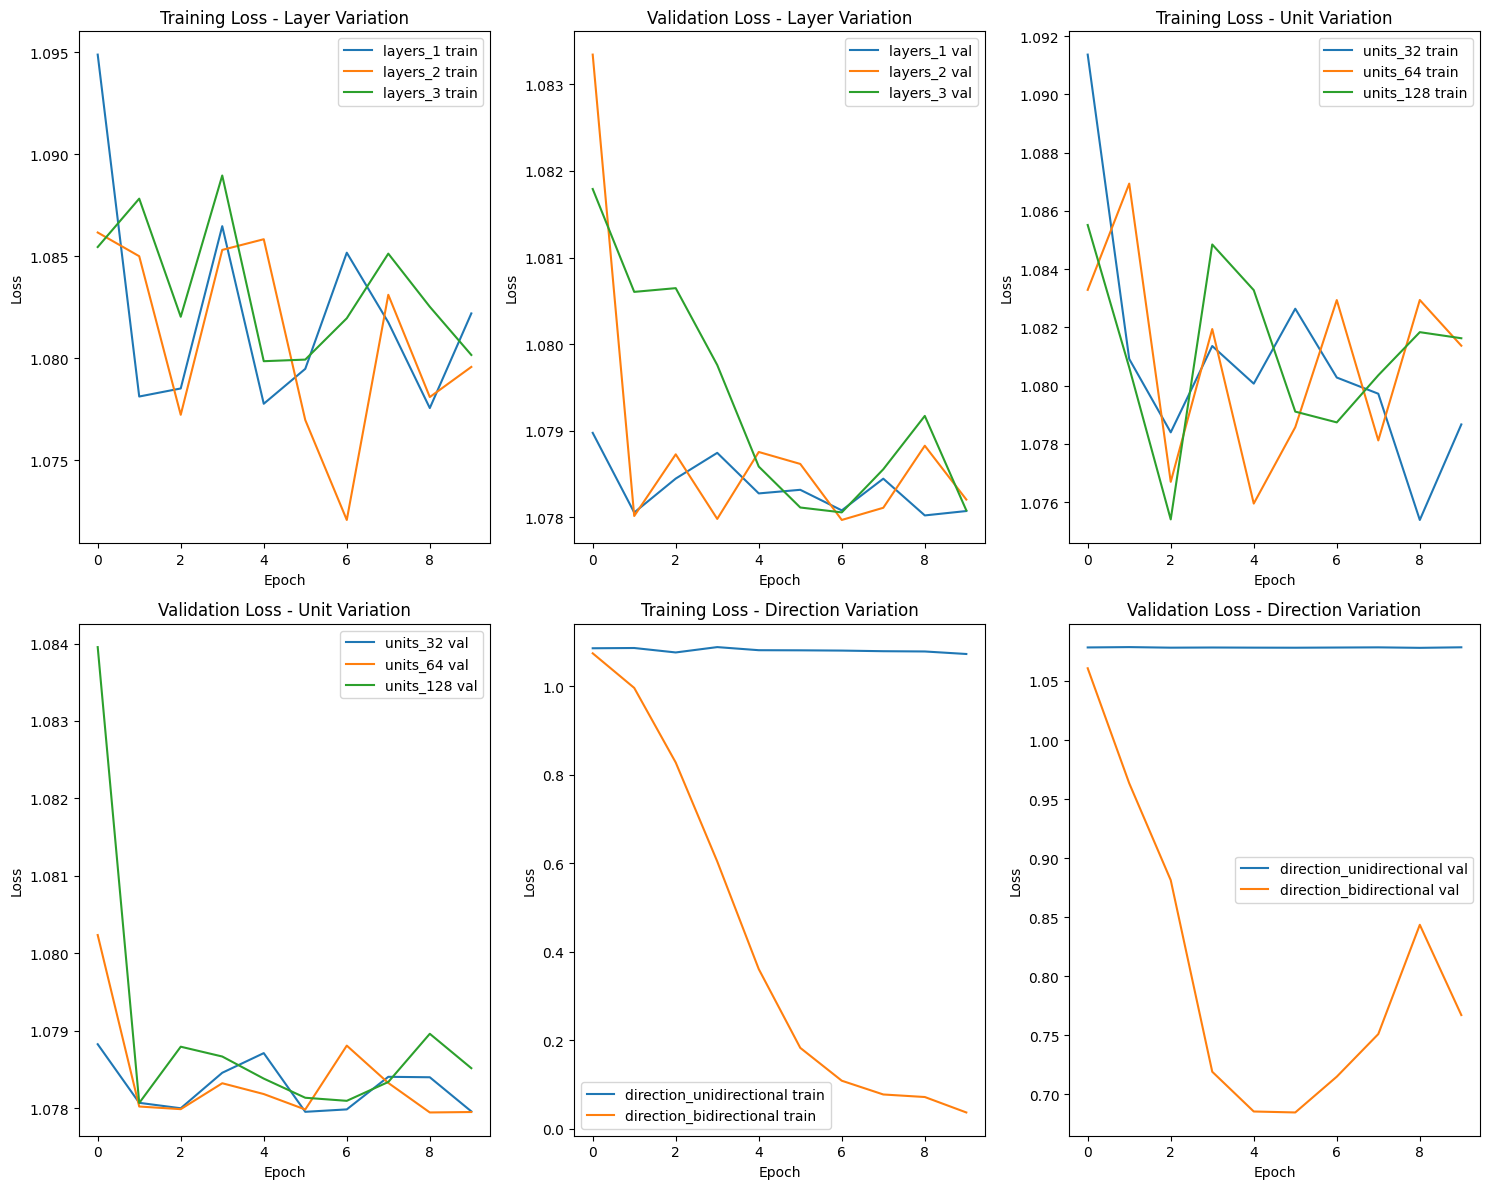

In [11]:
plot_training_curves()

In [12]:
save_models(models)


Saving models...
Saved layers_1.keras
Saved layers_2.keras
Saved layers_3.keras
Saved units_32.keras
Saved units_64.keras
Saved units_128.keras
Saved direction_unidirectional.keras
Saved direction_bidirectional.keras


In [13]:
import LSTM
import importlib
importlib.reload(LSTM)
from LSTM import LSTMModel

In [14]:
xs=[]
xy=[]
for batch_x, batch_y in test_ds:
  xs.append(batch_x)
  xy.append(batch_y)
x_array = np.concatenate(xs, axis=0)
y_array = np.concatenate(xy, axis=0)

#test scratch implementation
for model_name in os.listdir("lstm_models"):
    model_path = os.path.join("lstm_models", model_name)
    if os.path.isfile(model_path) and (model_name.endswith('.keras')):
        print(f"MODEL {model_name}")
        model = tf.keras.models.load_model(model_path)
        if "bidirectional" in model_name:
            lstm = LSTMModel(bidirectional=True)
        elif "units_" in model_name:
            lstm_units = int(model_name.split("_")[1].split(".")[0])
            lstm = LSTMModel(num_units=lstm_units)
        elif "layers_" in model_name:
            lstm_layers = int(model_name.split("_")[1].split(".")[0])
            lstm = LSTMModel(num_layers=lstm_layers)
        else:
            lstm = LSTMModel()
        lstm.load_keras_weights(model)
        keras_prediction = model.predict(test_ds)
        keras_prediction_label = np.argmax(keras_prediction, axis = 1)

        lstm_prediction = lstm.predict(x_array)
        lstm_predition_label = np.argmax(lstm_prediction, axis=1)

        print(x_array.shape)
        print(lstm_prediction.shape)
        test_labels = np.array(test_labels)
        print(test_labels.shape)

        keras_f1=f1_score(test_labels, keras_prediction_label, average='macro')
        lstm_f1=f1_score(test_labels, lstm_predition_label, average='macro')

        print(f"Keras f1score: {keras_f1:.4f}")
        print(f"Scratch f1score: {lstm_f1:.4f}")
        print(f"Difference: {abs(lstm_f1-keras_f1):.4f}")

        match = np.sum(keras_prediction_label == lstm_predition_label)
        percentage = (match/len(keras_prediction_label))*100
        print(f"Match percentage: {percentage:.4f}%")

MODEL direction_bidirectional.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
(400, 100)
(400, 3)
(400,)
Keras f1score: 0.7482
Scratch f1score: 0.6951
Difference: 0.0531
Match percentage: 81.5000%
MODEL direction_unidirectional.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
(400, 100)
(400, 3)
(400,)
Keras f1score: 0.1844
Scratch f1score: 0.1844
Difference: 0.0000
Match percentage: 100.0000%
MODEL layers_1.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
(400, 100)
(400, 3)
(400,)
Keras f1score: 0.1844
Scratch f1score: 0.1844
Difference: 0.0000
Match percentage: 100.0000%
MODEL layers_2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
(400, 100)
(400, 3)
(400,)
Keras f1score: 0.1844
Scratch f1score: 0.1844
Difference: 0.0000
Match percentage: 100.0000%
MODEL layers_3.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
(400, 100)
(400, 3)
(400,)
Keras f1score: 0.1844
Scratch f1score: 0.1844
Difference: 0.0000
Match percentage: 100.0000%
MODEL units_128.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
(40